In [16]:
import os
import torch
from torchvision import datasets, transforms
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from collections import defaultdict
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import Subset
import random

In [17]:
# Check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set the random seed for reproducibility
seed = 118
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)



Using device: cuda


In [18]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Calculate sizes for training and testing datasets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Define fixed indices for train and test splits
train_indices = list(range(train_size))
test_indices = list(range(train_size, len(dataset)))

# Create Subsets based on these indices
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_images = dataset.data[train_dataset.indices].numpy()
train_labels = dataset.targets[train_dataset.indices].numpy()
test_images = dataset.data[test_dataset.indices].numpy()
test_labels = dataset.targets[test_dataset.indices].numpy()


In [19]:
def partition_data(train_data, train_targets, test_data, test_targets, num_clients, dirichlet_alpha=0.5, batch_size=32):
    num_classes = len(np.unique(train_targets))
    client_data_indices = defaultdict(list)
    client_test_indices = defaultdict(list)

    # Partition Train Data and Capture Proportions
    client_proportions = []
    for c in range(num_classes):
        class_indices = np.where(train_targets == c)[0]
        proportions = np.random.dirichlet([dirichlet_alpha] * num_clients)
        client_proportions.append(proportions)

        # Calculate split sizes and assign indices to each client
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_data_indices[i].extend(indices)

    # Partition Test Data Using the Same Proportions as Train Data
    for c, proportions in enumerate(client_proportions):
        class_indices = np.where(test_targets == c)[0]
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_test_indices[i].extend(indices)

    # Create Federated Loaders
    federated_train_loaders, federated_test_loaders = [], []
    for i in range(num_clients):
        client_train_data = torch.tensor(train_data[client_data_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_train_targets = torch.tensor(train_targets[client_data_indices[i]], dtype=torch.long)
        train_loader = DataLoader(TensorDataset(client_train_data, client_train_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_train_loaders.append(train_loader)

        client_test_data = torch.tensor(test_data[client_test_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_test_targets = torch.tensor(test_targets[client_test_indices[i]], dtype=torch.long)
        test_loader = DataLoader(TensorDataset(client_test_data, client_test_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_test_loaders.append(test_loader)

    # Create Centralized Loader by combining data from federated loaders
    centralized_data, centralized_targets = [], []
    for train_loader in federated_train_loaders:
        for images, targets in train_loader:
            centralized_data.append(images)
            centralized_targets.append(targets)

    centralized_data = torch.cat(centralized_data)
    centralized_targets = torch.cat(centralized_targets)
    train_centralized_loader = DataLoader(TensorDataset(centralized_data, centralized_targets), batch_size=batch_size, shuffle=False, drop_last=False)

    centralized_test_data = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1)
    centralized_test_targets = torch.tensor(test_targets, dtype=torch.long)
    test_centralized_loader = DataLoader(TensorDataset(centralized_test_data, centralized_test_targets), batch_size=batch_size, shuffle=False)

    return federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader


In [20]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 500)
        self.fc2 = nn.Linear(500,10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
def evaluate_model(global_model, test_loaders):
    global_model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)

    client_accuracies = []
    total_correct, total_samples = 0, 0

    with torch.no_grad():
        for client_id, test_loader in enumerate(test_loaders):
            client_correct, client_total = 0, 0
            print(f"\nEvaluating Client {client_id}")

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = global_model(images)
                _, predicted = torch.max(outputs, 1)

                client_correct += (predicted == labels).sum().item()
                client_total += labels.size(0)

            client_accuracy = (client_correct / client_total) * 100
            client_accuracies.append(client_accuracy)

            print(f"Client {client_id} Accuracy: {client_accuracy:.2f}%")

            total_correct += client_correct
            total_samples += client_total

    total_accuracy = (total_correct / total_samples) * 100
    print(f"Total Accuracy: {total_accuracy:.2f}%")
    return client_accuracies, total_accuracy



# Task 4: Gradient Harmonization

In this task, you will examine how heterogeneity influences the gradient updates sent by each client. Specifically, you will analyze and quantify gradient conflicts at varying levels of heterogeneity.

First, implement the FedAvg code (You can reuse your task 2 implementation) and integrate the provided conflict-counting function at the end of each round to measure the number of conflicts in different heterogeneous settings.

Next, implement the Gradient Harmonization algorithm to harmonize conflicting gradients.

Finally, evaluate the performance of the harmonized gradients under a 0.1 Dirichlet scenario, and compare the number of conflicts before and after harmonization.

In [22]:
import builtins
from copy import deepcopy

sum = builtins.sum

def cosine_similarity(vec1, vec2):
    return torch.dot(vec1, vec2) / (torch.norm(vec1) * torch.norm(vec2))

def gradient_conflict_counter(client_updates):
    total_conflicts = 0  # Variable to store the total conflicts across all layers
    num_clients = len(client_updates)

    # Iterate over each layer (key) in the client updates
    for layer_name in client_updates[0].keys():
        # Collect vectors for this layer across all clients
        layer_vectors = [client_update[layer_name].view(-1).cpu() for client_update in client_updates]

        # Check pairwise cosine similarity for this layer and count conflicts
        for i in range(num_clients):
            for j in range(i + 1, num_clients):
                sim = cosine_similarity(layer_vectors[i], layer_vectors[j])
                if sim < 0:
                    total_conflicts += 1

    print(f"Total gradient conflicts detected: {total_conflicts}")
    return total_conflicts

def Federated_gradient_conflict(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
    round_avg_updates = []
    round_accuracies = []
    conflict_counts = []

    # Set the model to the device
    global_model.to(device)

    for round_num in range(rounds):
        print(f"\n--- Federated Round {round_num + 1}/{rounds} ---")
        client_updates = []

        # Progress bar for clients within each federated round
        progress_bar_inner = tqdm(range(num_clients), desc=f"Round {round_num + 1} - Clients", leave=False)

        for client_id in progress_bar_inner:
            # print(f"\nClient {client_id + 1}/{num_clients}")
            client_model = deepcopy(global_model)
            train_loader = train_loaders[client_id]
            optimizer = optim.SGD(client_model.parameters(), lr=lr)
            criterion = nn.CrossEntropyLoss()

            # Train the client model
            for epoch in range(epochs):
                client_model.train()
                epoch_loss = 0.0
                for data, targets in train_loader:
                    data, targets = data.to(device), targets.to(device)
                    optimizer.zero_grad()
                    outputs = client_model(data)
                    loss = criterion(outputs, targets)
                    loss.backward()
                    optimizer.step()

                    epoch_loss += loss.item()

                # Optional: Uncomment for more detailed logging per epoch
                # print(f"Client {client_id + 1} - Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

            # Compute the client update
            client_update = {name: param - global_model.state_dict()[name] for name, param in client_model.state_dict().items()}
            client_updates.append(client_update)

            # Update the progress bar with each client
            progress_bar_inner.set_postfix({"Client": f"{client_id + 1}/{num_clients}"})

        # Count conflicts for this round
        conflict_count = gradient_conflict_counter(client_updates)
        conflict_counts.append(conflict_count)

        # Aggregate updates
        aggregated_update = {name: torch.zeros_like(param) for name, param in global_model.state_dict().items()}
        for update in client_updates:
            for name in aggregated_update:
                aggregated_update[name] += update[name] / num_clients

        # Update the global model
        global_model_state = global_model.state_dict()
        for name in global_model_state:
            global_model_state[name] += aggregated_update[name]

        global_model.load_state_dict(global_model_state)

        # Evaluate the global model
        client_accuracies, accuracy = evaluate_model(global_model, test_loaders)
        round_accuracies.append(accuracy)

        print(f"Round {round_num + 1} Accuracy: {accuracy:.2f}%")

    return round_avg_updates, round_accuracies, conflict_counts

In [23]:
# Parameters
num_clients = 5
batch_size = 128
rounds = 3
epochs = 20
lr = 0.001
dirichlet_alphas = [2, 0.5, 0.1]

def run_fedconflict(alpha):
    train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_fedavg = SimpleCNN()
    _, round_accuracies,conflict_counts = Federated_gradient_conflict(global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
    return round_accuracies, conflict_counts

accuracies_per_alpha = []
conflicts_per_alpha = []

for alpha in dirichlet_alphas:
    print(f"\033[92mRunning for alpha: {alpha}\033[0m")  # Green text
    round_accuracies, conflict_counts = run_fedconflict(alpha)
    accuracies_per_alpha.append(round_accuracies)
    conflicts_per_alpha.append(conflict_counts)



Running for alpha: 2

--- Federated Round 1/3 ---


Total gradient conflicts detected: 11

Evaluating Client 0
Client 0 Accuracy: 16.08%

Evaluating Client 1
Client 1 Accuracy: 23.80%

Evaluating Client 2
Client 2 Accuracy: 31.16%

Evaluating Client 3
Client 3 Accuracy: 27.37%

Evaluating Client 4
Client 4 Accuracy: 40.78%
Total Accuracy: 27.88%
Round 1 Accuracy: 27.88%

--- Federated Round 2/3 ---


Total gradient conflicts detected: 0

Evaluating Client 0
Client 0 Accuracy: 42.74%

Evaluating Client 1
Client 1 Accuracy: 51.00%

Evaluating Client 2
Client 2 Accuracy: 48.61%

Evaluating Client 3
Client 3 Accuracy: 46.57%

Evaluating Client 4
Client 4 Accuracy: 57.73%
Total Accuracy: 49.18%
Round 2 Accuracy: 49.18%

--- Federated Round 3/3 ---


Total gradient conflicts detected: 0

Evaluating Client 0
Client 0 Accuracy: 57.51%

Evaluating Client 1
Client 1 Accuracy: 64.87%

Evaluating Client 2
Client 2 Accuracy: 65.36%

Evaluating Client 3
Client 3 Accuracy: 62.71%

Evaluating Client 4
Client 4 Accuracy: 70.58%
Total Accuracy: 64.12%
Round 3 Accuracy: 64.12%
Running for alpha: 0.5

--- Federated Round 1/3 ---


Total gradient conflicts detected: 19

Evaluating Client 0
Client 0 Accuracy: 7.40%

Evaluating Client 1
Client 1 Accuracy: 17.26%

Evaluating Client 2
Client 2 Accuracy: 23.17%

Evaluating Client 3
Client 3 Accuracy: 1.91%

Evaluating Client 4
Client 4 Accuracy: 0.41%
Total Accuracy: 9.81%
Round 1 Accuracy: 9.81%

--- Federated Round 2/3 ---


Total gradient conflicts detected: 10

Evaluating Client 0
Client 0 Accuracy: 16.61%

Evaluating Client 1
Client 1 Accuracy: 29.60%

Evaluating Client 2
Client 2 Accuracy: 63.16%

Evaluating Client 3
Client 3 Accuracy: 41.96%

Evaluating Client 4
Client 4 Accuracy: 50.78%
Total Accuracy: 37.50%
Round 2 Accuracy: 37.50%

--- Federated Round 3/3 ---


Total gradient conflicts detected: 4

Evaluating Client 0
Client 0 Accuracy: 53.70%

Evaluating Client 1
Client 1 Accuracy: 57.44%

Evaluating Client 2
Client 2 Accuracy: 75.50%

Evaluating Client 3
Client 3 Accuracy: 52.90%

Evaluating Client 4
Client 4 Accuracy: 71.29%
Total Accuracy: 61.10%
Round 3 Accuracy: 61.10%
Running for alpha: 0.1

--- Federated Round 1/3 ---


Total gradient conflicts detected: 22

Evaluating Client 0
Client 0 Accuracy: 7.00%

Evaluating Client 1
Client 1 Accuracy: 0.00%

Evaluating Client 2
Client 2 Accuracy: 4.52%

Evaluating Client 3
Client 3 Accuracy: 0.56%

Evaluating Client 4
Client 4 Accuracy: 34.65%
Total Accuracy: 10.81%
Round 1 Accuracy: 10.81%

--- Federated Round 2/3 ---


Total gradient conflicts detected: 23

Evaluating Client 0
Client 0 Accuracy: 23.55%

Evaluating Client 1
Client 1 Accuracy: 1.28%

Evaluating Client 2
Client 2 Accuracy: 4.65%

Evaluating Client 3
Client 3 Accuracy: 4.46%

Evaluating Client 4
Client 4 Accuracy: 38.10%
Total Accuracy: 15.88%
Round 2 Accuracy: 15.88%

--- Federated Round 3/3 ---


Total gradient conflicts detected: 25

Evaluating Client 0
Client 0 Accuracy: 59.17%

Evaluating Client 1
Client 1 Accuracy: 17.18%

Evaluating Client 2
Client 2 Accuracy: 37.80%

Evaluating Client 3
Client 3 Accuracy: 39.58%

Evaluating Client 4
Client 4 Accuracy: 64.88%
Total Accuracy: 45.41%
Round 3 Accuracy: 45.41%


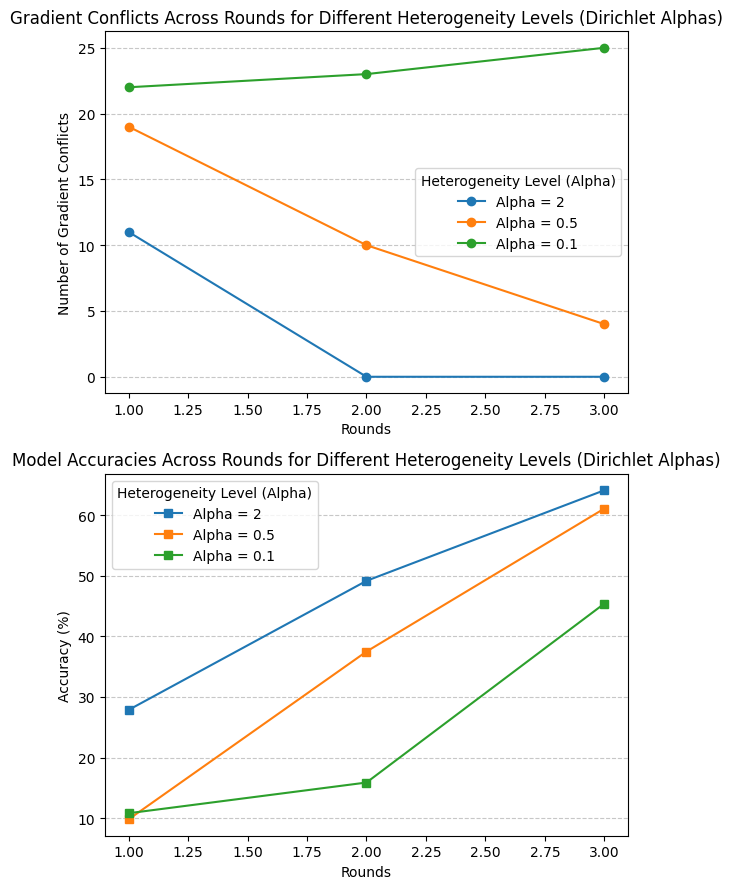

In [24]:
# Create a figure
plt.figure(figsize=(6, 9))

# Plot Gradient Conflicts
plt.subplot(2, 1, 1)
for i, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), conflicts_per_alpha[i], marker='o', label=f'Alpha = {alpha}')
plt.xlabel("Rounds")
plt.ylabel("Number of Gradient Conflicts")
plt.title("Gradient Conflicts Across Rounds for Different Heterogeneity Levels (Dirichlet Alphas)")
plt.legend(title="Heterogeneity Level (Alpha)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Plot Accuracies
plt.subplot(2, 1, 2)
for i, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), accuracies_per_alpha[i], marker='s', label=f'Alpha = {alpha}')
plt.xlabel("Rounds")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracies Across Rounds for Different Heterogeneity Levels (Dirichlet Alphas)")
plt.legend(title="Heterogeneity Level (Alpha)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [25]:
def gradient_harmonization(client_updates):
    num_clients = len(client_updates)
    harmonized_updates = client_updates.copy()

    # For each layer in client updates
    for layer_name in client_updates[0].keys():
        layer_vectors = [client_update[layer_name].view(-1) for client_update in client_updates]

        # Pairwise conflict resolution
        for i in range(num_clients):
            for j in range(i + 1, num_clients):
                g_i = layer_vectors[i]
                g_j = layer_vectors[j]

                # Calculate cosine similarity
                sim = cosine_similarity(g_i, g_j)

                # If the cosine similarity is negative, there is a conflict
                if sim < 0:
                    # print(f"Conflict detected between clients {i} and {j}")
                    g_i_tilde = g_i.clone()
                    g_j_tilde = g_j.clone()

                    # Project gradients onto the orthogonal complement
                    projection_i = torch.dot(g_i, g_j_tilde) / (torch.norm(g_j_tilde) ** 2) * g_j_tilde
                    projection_j = torch.dot(g_j, g_i_tilde) / (torch.norm(g_i_tilde) ** 2) * g_i_tilde

                    g_i -= projection_i
                    g_j -= projection_j

                    layer_vectors[i] = g_i
                    layer_vectors[j] = g_j

        # Update harmonized updates for this layer
        for k in range(num_clients):
            harmonized_updates[k][layer_name] = layer_vectors[k].view_as(client_updates[k][layer_name])

    return harmonized_updates



def Federated_gradient_harmonization(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
    round_accuracies = []  # List to store total accuracy after each round
    pre_harmonization_conflicts = []  # List to store conflicts before harmonization
    post_harmonization_conflicts = []  # List to store conflicts after harmonization

    # Set the model to the device
    global_model.to(device)

    for round_num in range(rounds):
        print(f"\n--- Federated Round {round_num + 1}/{rounds} ---")
        client_updates = []

        # Initialize the progress bar for clients
        progress_bar = tqdm(range(num_clients), desc=f"Round {round_num + 1}/{rounds} - Clients", leave=True)

        for client_id in progress_bar:
            # print(f"\nClient {client_id + 1}/{num_clients}")
            client_model = deepcopy(global_model)
            train_loader = train_loaders[client_id]
            optimizer = optim.SGD(client_model.parameters(), lr=lr)
            criterion = nn.CrossEntropyLoss()

            # Train the client model
            for epoch in range(epochs):
                client_model.train()
                epoch_loss = 0.0
                # epoch_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)

                for data, targets in train_loader:
                    data, targets = data.to(device), targets.to(device)
                    optimizer.zero_grad()
                    outputs = client_model(data)
                    loss = criterion(outputs, targets)
                    loss.backward()
                    optimizer.step()

                    epoch_loss += loss.item()
                    # epoch_progress_bar.set_postfix({"Loss": epoch_loss / len(train_loader)})

            # Compute the client update
            client_update = {name: param - global_model.state_dict()[name] for name, param in client_model.state_dict().items()}
            client_updates.append(client_update)

            # Update the progress bar for client
            progress_bar.set_postfix({"Client": f"{client_id + 1}/{num_clients}"})

        # Count conflicts for this round before harmonization
        pre_harmonization_conflicts.append(gradient_conflict_counter(client_updates))

        # Harmonize the gradients
        harmonized_updates = gradient_harmonization(client_updates)

        # Count conflicts for this round after harmonization
        post_harmonization_conflicts.append(gradient_conflict_counter(harmonized_updates))

        print(f"Round {round_num + 1} - Pre-Harmonization Conflicts: {pre_harmonization_conflicts[-1]} - Post-Harmonization Conflicts: {post_harmonization_conflicts[-1]}")

        # Aggregate updates
        aggregated_update = {name: torch.zeros_like(param) for name, param in global_model.state_dict().items()}
        for update in harmonized_updates:
            for name in aggregated_update:
                aggregated_update[name] += update[name] / num_clients

        # Update the global model
        global_model_state = global_model.state_dict()
        for name in global_model_state:
            global_model_state[name] += aggregated_update[name]

        global_model.load_state_dict(global_model_state)

        # Evaluate the global model
        client_accuracies, accuracy = evaluate_model(global_model, test_loaders)
        round_accuracies.append(accuracy)
        print(f"Round {round_num + 1} Accuracy: {accuracy :.2f}%")

    return round_accuracies, pre_harmonization_conflicts, post_harmonization_conflicts



In [26]:
# Parameters
num_clients = 5
batch_size = 128
rounds = 3
epochs = 20
lr = 0.001
alphas = [2, 0.5, 0.1]

# Store results for each alpha
results = {}

# Run experiments for different alphas
for alpha in alphas:
    print(f"\033[92mRunning for alpha: {alpha}\033[0m")  # Green text
    # Partition the data
    train_loaders, test_loaders, _, _ = partition_data(
        train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size
    )

    # Initialize the global model
    global_model_fedavg = SimpleCNN()

    # Run Federated Gradient Harmonization
    round_accuracies, pre_harmonization_conflicts, post_harmonization_conflicts = Federated_gradient_harmonization(
        global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders
    )

    # Store results
    results[alpha] = {
        "round_accuracies": round_accuracies,
        "pre_harmonization_conflicts": pre_harmonization_conflicts,
        "post_harmonization_conflicts": post_harmonization_conflicts,
    }


Running for alpha: 2

--- Federated Round 1/3 ---


Round 1/3 - Clients: 100%|██████████| 5/5 [00:22<00:00,  4.57s/it, Client=5/5]


Total gradient conflicts detected: 8
Total gradient conflicts detected: 0
Round 1 - Pre-Harmonization Conflicts: 8 - Post-Harmonization Conflicts: 0

Evaluating Client 0
Client 0 Accuracy: 46.85%

Evaluating Client 1
Client 1 Accuracy: 47.31%

Evaluating Client 2
Client 2 Accuracy: 53.90%

Evaluating Client 3
Client 3 Accuracy: 56.10%

Evaluating Client 4
Client 4 Accuracy: 44.52%
Total Accuracy: 49.44%
Round 1 Accuracy: 49.44%

--- Federated Round 2/3 ---


Round 2/3 - Clients: 100%|██████████| 5/5 [00:22<00:00,  4.55s/it, Client=5/5]


Total gradient conflicts detected: 1
Total gradient conflicts detected: 0
Round 2 - Pre-Harmonization Conflicts: 1 - Post-Harmonization Conflicts: 0

Evaluating Client 0
Client 0 Accuracy: 49.62%

Evaluating Client 1
Client 1 Accuracy: 53.32%

Evaluating Client 2
Client 2 Accuracy: 60.61%

Evaluating Client 3
Client 3 Accuracy: 58.48%

Evaluating Client 4
Client 4 Accuracy: 48.31%
Total Accuracy: 53.82%
Round 2 Accuracy: 53.82%

--- Federated Round 3/3 ---


Round 3/3 - Clients: 100%|██████████| 5/5 [00:22<00:00,  4.57s/it, Client=5/5]


Total gradient conflicts detected: 0
Total gradient conflicts detected: 0
Round 3 - Pre-Harmonization Conflicts: 0 - Post-Harmonization Conflicts: 0

Evaluating Client 0
Client 0 Accuracy: 62.97%

Evaluating Client 1
Client 1 Accuracy: 64.63%

Evaluating Client 2
Client 2 Accuracy: 72.61%

Evaluating Client 3
Client 3 Accuracy: 70.62%

Evaluating Client 4
Client 4 Accuracy: 62.72%
Total Accuracy: 66.53%
Round 3 Accuracy: 66.53%
Running for alpha: 0.5

--- Federated Round 1/3 ---


Round 1/3 - Clients: 100%|██████████| 5/5 [00:22<00:00,  4.59s/it, Client=5/5]


Total gradient conflicts detected: 18
Total gradient conflicts detected: 0
Round 1 - Pre-Harmonization Conflicts: 18 - Post-Harmonization Conflicts: 0

Evaluating Client 0
Client 0 Accuracy: 36.13%

Evaluating Client 1
Client 1 Accuracy: 24.21%

Evaluating Client 2
Client 2 Accuracy: 36.80%

Evaluating Client 3
Client 3 Accuracy: 24.76%

Evaluating Client 4
Client 4 Accuracy: 42.43%
Total Accuracy: 31.08%
Round 1 Accuracy: 31.08%

--- Federated Round 2/3 ---


Round 2/3 - Clients: 100%|██████████| 5/5 [00:22<00:00,  4.59s/it, Client=5/5]


Total gradient conflicts detected: 5
Total gradient conflicts detected: 0
Round 2 - Pre-Harmonization Conflicts: 5 - Post-Harmonization Conflicts: 0

Evaluating Client 0
Client 0 Accuracy: 60.23%

Evaluating Client 1
Client 1 Accuracy: 43.15%

Evaluating Client 2
Client 2 Accuracy: 56.34%

Evaluating Client 3
Client 3 Accuracy: 40.38%

Evaluating Client 4
Client 4 Accuracy: 62.10%
Total Accuracy: 49.85%
Round 2 Accuracy: 49.85%

--- Federated Round 3/3 ---


Round 3/3 - Clients: 100%|██████████| 5/5 [00:22<00:00,  4.57s/it, Client=5/5]


Total gradient conflicts detected: 0
Total gradient conflicts detected: 0
Round 3 - Pre-Harmonization Conflicts: 0 - Post-Harmonization Conflicts: 0

Evaluating Client 0
Client 0 Accuracy: 73.56%

Evaluating Client 1
Client 1 Accuracy: 49.89%

Evaluating Client 2
Client 2 Accuracy: 70.74%

Evaluating Client 3
Client 3 Accuracy: 55.38%

Evaluating Client 4
Client 4 Accuracy: 72.19%
Total Accuracy: 62.48%
Round 3 Accuracy: 62.48%
Running for alpha: 0.1

--- Federated Round 1/3 ---


Round 1/3 - Clients: 100%|██████████| 5/5 [00:22<00:00,  4.60s/it, Client=5/5]


Total gradient conflicts detected: 18
Total gradient conflicts detected: 0
Round 1 - Pre-Harmonization Conflicts: 18 - Post-Harmonization Conflicts: 0

Evaluating Client 0
Client 0 Accuracy: 3.83%

Evaluating Client 1
Client 1 Accuracy: 2.99%

Evaluating Client 2
Client 2 Accuracy: 6.25%

Evaluating Client 3
Client 3 Accuracy: 56.72%

Evaluating Client 4
Client 4 Accuracy: 90.74%
Total Accuracy: 12.15%
Round 1 Accuracy: 12.15%

--- Federated Round 2/3 ---


Round 2/3 - Clients: 100%|██████████| 5/5 [00:22<00:00,  4.55s/it, Client=5/5]


Total gradient conflicts detected: 23
Total gradient conflicts detected: 0
Round 2 - Pre-Harmonization Conflicts: 23 - Post-Harmonization Conflicts: 0

Evaluating Client 0
Client 0 Accuracy: 10.71%

Evaluating Client 1
Client 1 Accuracy: 33.89%

Evaluating Client 2
Client 2 Accuracy: 31.92%

Evaluating Client 3
Client 3 Accuracy: 56.91%

Evaluating Client 4
Client 4 Accuracy: 96.45%
Total Accuracy: 27.25%
Round 2 Accuracy: 27.25%

--- Federated Round 3/3 ---


Round 3/3 - Clients: 100%|██████████| 5/5 [00:22<00:00,  4.59s/it, Client=5/5]


Total gradient conflicts detected: 22
Total gradient conflicts detected: 0
Round 3 - Pre-Harmonization Conflicts: 22 - Post-Harmonization Conflicts: 0

Evaluating Client 0
Client 0 Accuracy: 20.94%

Evaluating Client 1
Client 1 Accuracy: 45.75%

Evaluating Client 2
Client 2 Accuracy: 37.58%

Evaluating Client 3
Client 3 Accuracy: 66.11%

Evaluating Client 4
Client 4 Accuracy: 92.01%
Total Accuracy: 36.07%
Round 3 Accuracy: 36.07%


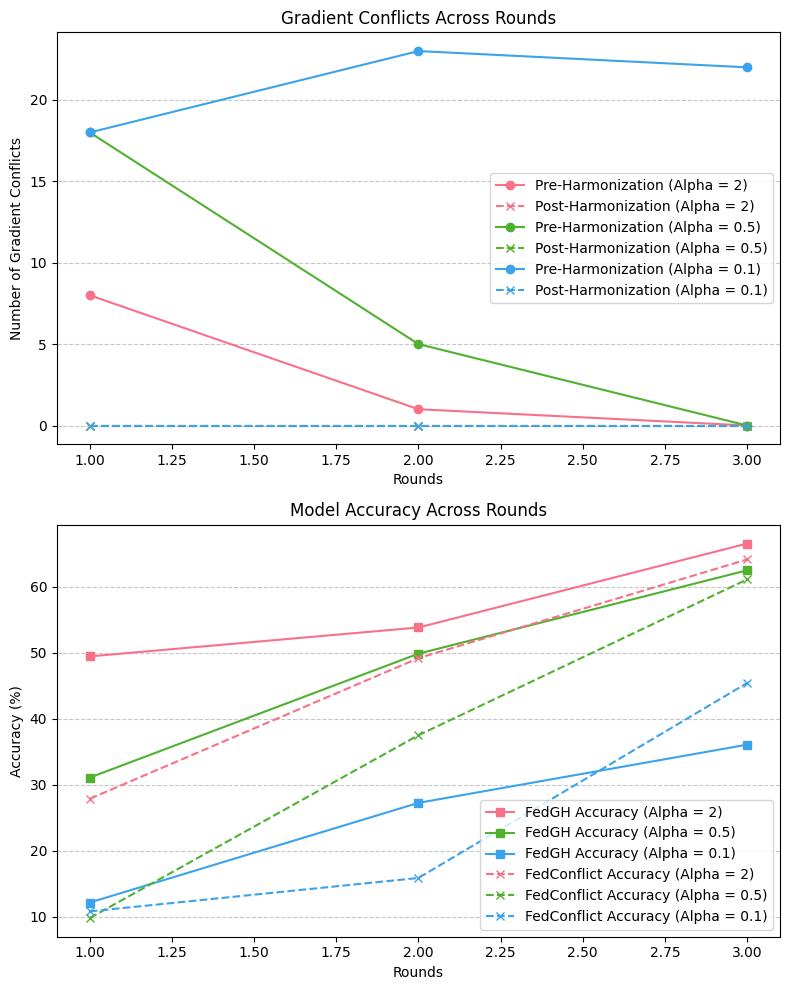

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a consistent color palette for alphas
color_palette = sns.color_palette("husl", len(alphas))  # Unique colors for each alpha

# Create a figure
plt.figure(figsize=(8, 10))

# Plot Gradient Conflicts (Overlayed)
plt.subplot(2, 1, 1)
for idx, alpha in enumerate(alphas):
    color = color_palette[idx]
    plt.plot(
        range(1, rounds + 1),
        results[alpha]["pre_harmonization_conflicts"],
        marker='o', linestyle='-', color=color, label=f'Pre-Harmonization (Alpha = {alpha})'
    )
    plt.plot(
        range(1, rounds + 1),
        results[alpha]["post_harmonization_conflicts"],
        marker='x', linestyle='--', color=color, label=f'Post-Harmonization (Alpha = {alpha})'
    )
plt.xlabel("Rounds")
plt.ylabel("Number of Gradient Conflicts")
plt.title("Gradient Conflicts Across Rounds")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Plot Model Accuracy (Overlayed)
plt.subplot(2, 1, 2)
# Plot FedGH accuracies with consistent colors
for idx, alpha in enumerate(alphas):
    color = color_palette[idx]
    plt.plot(
        range(1, rounds + 1),
        results[alpha]["round_accuracies"],
        marker='s', linestyle='-', color=color, label=f'FedGH Accuracy (Alpha = {alpha})'
    )

# Plot FedConflict accuracies with consistent colors
for idx, alpha in enumerate(dirichlet_alphas):
    color = color_palette[alphas.index(alpha)] if alpha in alphas else "gray"  # Default color for unmatched alpha
    plt.plot(
        range(1, rounds + 1),
        accuracies_per_alpha[idx],
        marker='x', linestyle='--', color=color, label=f'FedConflict Accuracy (Alpha = {alpha})'
    )

plt.xlabel("Rounds")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Across Rounds")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [28]:
from tabulate import tabulate

# Prepare data for conflicts table
conflicts_table = [["Alpha", "Round", "Pre-Harmonization Conflicts", "Post-Harmonization Conflicts"]]
for alpha in alphas:
    for round_num in range(1, rounds + 1):
        conflicts_table.append([
            alpha,
            round_num,
            results[alpha]["pre_harmonization_conflicts"][round_num - 1],
            results[alpha]["post_harmonization_conflicts"][round_num - 1]
        ])

# Prepare data for accuracies table
accuracies_table = [["Alpha", "Round", "FedGH Accuracy", "FedConflict Accuracy"]]
for idx, alpha in enumerate(alphas):
    for round_num in range(1, rounds + 1):
        fedgh_accuracy = results[alpha]["round_accuracies"][round_num - 1]
        fedconflict_accuracy = accuracies_per_alpha[idx][round_num - 1]
        accuracies_table.append([alpha, round_num, f"{fedgh_accuracy:.2f}%", f"{fedconflict_accuracy:.2f}%"])

# Print conflicts table
print("Gradient Conflicts Table:")
print(tabulate(conflicts_table, headers="firstrow", tablefmt="grid"))

# Print accuracies table
print("\nModel Accuracies Table:")
print(tabulate(accuracies_table, headers="firstrow", tablefmt="grid"))


Gradient Conflicts Table:
+---------+---------+-------------------------------+--------------------------------+
|   Alpha |   Round |   Pre-Harmonization Conflicts |   Post-Harmonization Conflicts |
+=========+=========+===============================+================================+
|     2   |       1 |                             8 |                              0 |
+---------+---------+-------------------------------+--------------------------------+
|     2   |       2 |                             1 |                              0 |
+---------+---------+-------------------------------+--------------------------------+
|     2   |       3 |                             0 |                              0 |
+---------+---------+-------------------------------+--------------------------------+
|     0.5 |       1 |                            18 |                              0 |
+---------+---------+-------------------------------+--------------------------------+
|     0.5 |      